In [29]:
import xarray as xr
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import Tensor
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

import sys
sys.path.append('../')

from pytorch_utils.data_pipeline import TSData

## Data loder for a sequential model

* For the training loader, we use a window size of 100 time steps from the range 1980-01-01 to 2000-12-31
* For the validation loader, we use the entire sequence 2001-01-01 to 2020-12-31

In [30]:
ds = xr.open_zarr('../simple_sm_model/data/era5_40N6W.zarr').load()

train_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['et', 'tp'], targets='sm', time_slice=slice('1980', '2000'), return_seq=True, ts_window_size=365),
    batch_size=50,
    shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['et', 'tp'], targets='sm', time_slice=slice('2001', '2020'), return_seq=True, ts_window_size=-1, norm_stats=train_loader.dataset.norm_stats),
    batch_size=1,
    shuffle=False)

## We can iterate the data in batches of size 50

In [31]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape, y.shape)

    if i > 3:
        break


torch.Size([50, 365, 2]) torch.Size([50, 365, 1])
torch.Size([50, 365, 2]) torch.Size([50, 365, 1])
torch.Size([50, 365, 2]) torch.Size([50, 365, 1])
torch.Size([50, 365, 2]) torch.Size([50, 365, 1])
torch.Size([50, 365, 2]) torch.Size([50, 365, 1])


In [32]:
x.shape

torch.Size([50, 365, 2])

In [40]:
class LSTM(nn.Module):
    def __init__(
            self,
            num_features: int,
            num_targets: int=1,
            num_hidden: int=8,
            learning_rate: float = 0.001,
            weight_decay: float = 0.0) -> None:
        """A fully connected feed-forward model.
        
        Parameters
        -----------
        num_features: int
            The number of input features.
        num_targets: int (default is 1)
            The number of targets.
        num_hidden: int (default is 8)
            The number of hidden nodes per layer.
        learning_rate: float (default is 0.001):
            The learning rate.
        weight_decay: float (default is 0.0)
            The weight decay (L2 regularization).
        """
        super().__init__()

        self.lstm = nn.LSTM(input_size=num_features, hidden_size=num_hidden, batch_first=True)
        self.linear = nn.Linear(in_features=num_hidden, out_features=num_targets)

        self.optimizer = self.get_optimizer(self.parameters(), learning_rate=learning_rate, weight_decay=weight_decay)

        self.loss_fn = nn.MSELoss()

    def forward(self, x: Tensor) -> Tensor:

        out, _ = self.lstm(x)
        out = self.linear(out)

        return out

    def train_epoch(self, train_loader: torch.utils.data.DataLoader) -> Tensor:
        self.train()

        loss_sum = torch.zeros(1)
        loss_counter = 0

        for x, y in train_loader:
            self.optimizer.zero_grad()

            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)
            loss.backward()

            self.optimizer.step()

            loss_sum += loss.item()
            loss_counter += 1
        
        return (loss_sum / loss_counter).item()

    @torch.no_grad()
    def eval_epoch(self, valid_loader: torch.utils.data.DataLoader) -> Tensor:
        self.eval()

        loss_sum = torch.zeros(1)
        loss_counter = 0

        for x, y in valid_loader:

            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)

        loss_sum += loss.item()
        loss_counter += 1

        return (loss_sum / loss_counter).item()

    def tune(self, num_epochs: int, train_loader: torch.utils.data.DataLoader, valid_loader: torch.utils.data.DataLoader) -> None:
        self.train_losses = np.zeros(num_epochs)
        self.valid_losses = np.zeros(num_epochs)

        train_loss = -1
        valid_loss = -1
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            pbar.set_description(f'train loss: {train_loss}, valid loss: {valid_loss}')

            train_loss = self.train_epoch(train_loader=train_loader)
            valid_loss = self.eval_epoch(valid_loader=valid_loader)

            self.train_losses[epoch] = train_loss
            self.valid_losses[epoch] = valid_loss

    def get_optimizer(self, params: torch.ParameterDict, learning_rate: float = 0.001, weight_decay: float = 0.0) -> torch.optim.Optimizer:
        return torch.optim.AdamW(params, lr=learning_rate, weight_decay=weight_decay)


In [56]:
model = LSTM(num_features=2, learning_rate=0.01)

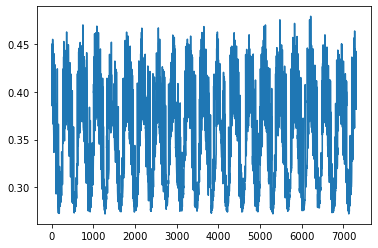

In [57]:
plt.plot(model(x)[0, :, 0].detach().numpy())

In [58]:
model.tune(num_epochs=10, train_loader=train_loader, valid_loader=valid_loader)

train loss: 0.4516151547431946, valid loss: 0.3011382222175598: 100%|██████████| 10/10 [01:31<00:00,  9.20s/it] 


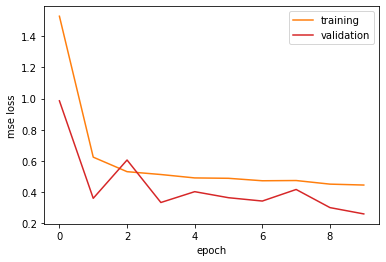

In [59]:
plt.plot(model.train_losses, label='training', color='tab:orange')
plt.plot(model.valid_losses, label='validation', color='tab:red')

plt.xlabel('epoch')
plt.ylabel('mse loss')

plt.legend()

In [60]:
x, y = next(iter(valid_loader))

In [61]:
y_hat = model(x)

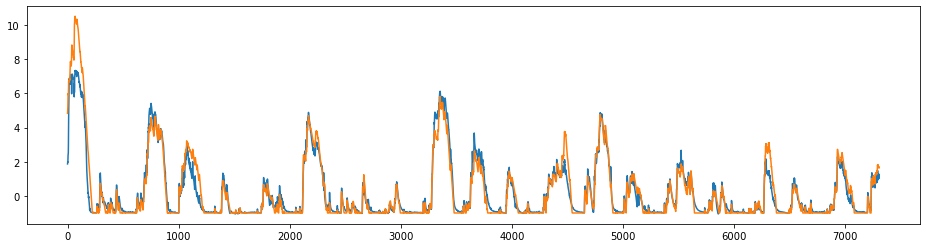

In [62]:
plt.figure(figsize=(16, 4))
plt.plot(y_hat[0, :, 0].detach().numpy())
plt.plot(y[0, :, 0].detach().numpy())